# Problem Set 7
### Suleyman Gozen


I thank Rebekah Dix. 

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Problem 1

In [2]:
def opt_newton(Df, D2f, x, maxiter=100, tol=1e-5):
    
    converged = False
    xk = x
    it = 0
    err = tol + 1
    
    while it < maxiter and err > tol:
        Dfxk = Df(xk)
        D2fxk = D2f(xk)
        
        zk = np.linalg.solve(D2fxk, Dfxk)
        xkp1 = xk - zk
        
        err = np.linalg.norm(Dfxk, np.inf)
        it += 1
        
        xk = xkp1
        
    if it < maxiter:
        converged = True
    
    return xk, converged, it

In [3]:
opt_newton(opt.rosen_der, opt.rosen_hess, np.array([-2, 2]))

(array([1., 1.]), True, 6)

Let's compare with a scipy routine:

In [4]:
opt.fmin_bfgs(opt.rosen, np.array([-2, 2]), fprime=opt.rosen_der)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 42
         Gradient evaluations: 42


array([1.00000021, 1.00000045])

# Problem 2

In [5]:
def bfgs(Df, x, maxiter=500, tol=1e-5):
    
    n = len(x)
    Akinv = np.eye(n)
    
    converged = False
    terminateEarly = False
    xk = x
    it = 0
    err = tol + 1
    
    while it < maxiter and err > tol:
        
        Dfxk = Df(xk)
        xkp1 = xk - Akinv @ Dfxk.T
        
        # Update A_k
        sk = xkp1 - xk
        Dfxkp1 = Df(xkp1)
        yk = Dfxkp1.T - Dfxk.T
        skdotyk = sk.T @ yk
        
        term1den = (skdotyk) ** 2
        if term1den < 1e-50:
            print('Terminated because dviding by 0.')
            terminateEarly = True
            converged = False
            break
        term1num = (skdotyk + yk.T @ Akinv @ yk) * np.outer(sk, sk)
        
        term2num = Akinv @ np.outer(yk, sk) + np.outer(sk, yk) @ Akinv
        term2den = skdotyk
        
        Akp1inv = Akinv + term1num/term1den - term2num/term2den
        
        # Update stopping conditions
        err = np.linalg.norm(Dfxk, np.inf)
        it += 1
        
        xk = xkp1
        Akinv = Akp1inv
        
    if it < maxiter and not terminateEarly:
        converged = True
        
    return xk, converged, it



In [6]:
bfgs(opt.rosen_der, np.array([-2, 2]))

(array([0.99999999, 0.99999998]), True, 149)

# Problem 3

In [7]:
import time

def compare_methods(N):
    
    time_newton = np.zeros(N, dtype=np.float64)
    time_bfgs = np.zeros(N, dtype=np.float64)
    time_scipy = np.zeros(N, dtype=np.float64)
    
    its_newton = np.zeros(N)
    its_bfgs = np.zeros(N)
    its_scipy = np.zeros(N)
    
    for ii in range(N):
        # Sample a random initial guess x_0 from the 
        # 2-D uniform distribution over [−3, 3] × [−3, 3].
        x = np.random.uniform(low=-3, high=3, size=2)
    
        time_start_exact = time.time()
        xk, converged, it = opt_newton(opt.rosen_der, opt.rosen_hess, x)
        time_newton[ii] =  time.time() - time_start_exact
        its_newton[ii] = it
        
        time_start_exact = time.time()
        xk, converged, it = bfgs(opt.rosen_der, x)
        time_bfgs[ii] =  time.time() - time_start_exact
        its_bfgs[ii] = it
        
        time_start_exact = time.time()
        out = opt.fmin_bfgs(opt.rosen, x, fprime=opt.rosen_der, disp=False, retall=1)
        time_scipy[ii] =  time.time() - time_start_exact
        its_scipy[ii] = len(out[1])
    
    fig = plt.figure(figsize=(10,7))
    plt.loglog()
    plt.scatter(time_newton, its_newton, alpha=0.5, label='Newton\'s Method')
    plt.scatter(time_bfgs, its_bfgs, alpha=0.5, label='BFGS')
    plt.scatter(time_scipy, its_scipy, alpha=0.5, label='scipy.optimize.fmin_bfgs()')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Iterations')
    plt.title('Comparing Computation Time and Iterations Across Minimizers')
    plt.legend()
    plt.show()
    
    

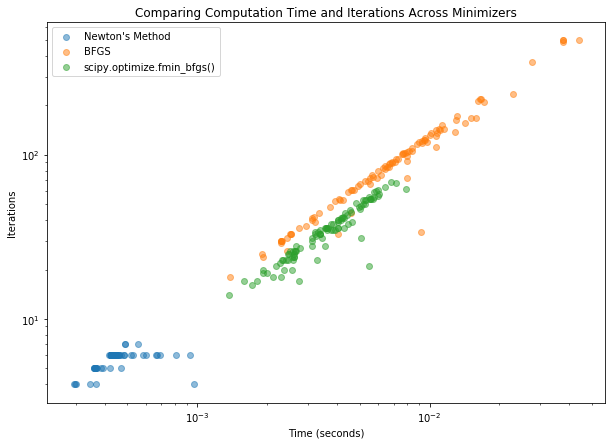

In [8]:
compare_methods(100)

# Problem 4

In [9]:
def gnm(phi, r, J, x, maxiter=500, tol=1e-5):
   
    converged = False
    
    xk = x
    err = tol + 1
    it = 0
    
    while it < maxiter and err > tol:
        rxk = r(xk)
        Jxk = J(xk)
        Dfxk = Jxk.T @ rxk
        D2fxk = Jxk.T @ Jxk
        zk = np.linalg.solve(D2fxk, Dfxk)
        
        xkp1 = xk - zk
        err = np.linalg.norm(xkp1 - xk, np.inf)
        it += 1
        xk = xkp1
        
    if it < maxiter:
        converged = True
        
    return xk, converged, it

In [10]:
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))

In [11]:
x0=np.array([2.5,.6])
gnm(model, residual, jac, x0, maxiter=500, tol=1e-5)

(array([2.63722036, 0.47947823]), True, 5)

In [12]:
minx = opt.leastsq(func=residual, x0=np.array([2.5,.6]), Dfun=jac)
minx

(array([2.63722036, 0.47947823]), 1)